# Compare obs to reanalyses/models
- **HadISST/PCMDI** (SST from Chongxing)
- **CERES** (LW/SW from Ryan Kramer)
- **OISST** (SST from NOAA)

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy import stats
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import linregress
import jo_regress

# HadISST
(dir: `/work/c1f/data/AM5_Inputs/downloads/`)

In [2]:
hadisst_ds = xr.open_dataset('/work/c1f/data/AM5_Inputs/downloads/HadISST_sst.nc', chunks={})
pcmdi_ds = xr.open_dataset('/work/c1f/data/AM5_Inputs/downloads/tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc',
                           chunks={})

In [3]:
pcmdi_ds.tosbcs

<xarray.DataArray 'tosbcs' (time: 1836, lat: 180, lon: 360)> Size: 476MB
dask.array<open_dataset-tosbcs, shape=(1836, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 15kB 1870-01-16T12:00:00 ... 2022-12-16T12...
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Constructed mid-month Sea Surface Temperature
    units:          degC
    cell_methods:   time: point
    cell_measures:  area: areacello

In [4]:
hadisst_ds.sst

<xarray.DataArray 'sst' (time: 1853, latitude: 180, longitude: 360)> Size: 480MB
dask.array<open_dataset-sst, shape=(1853, 180, 360), dtype=float32, chunksize=(1853, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 2...
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

In [5]:
pcmdi_ds.tosbcs.coords

Coordinates:
  * time     (time) datetime64[ns] 15kB 1870-01-16T12:00:00 ... 2022-12-16T12...
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5

In [6]:
#1983-2021-06-30
gom = dict(latitude=slice(31.5, 17.5), longitude=slice(-99,-80), time=slice('1983', '2021-06-30'))
gom_pcm = dict(lat=slice(17.5,31), lon=slice(261,281), time=slice('1983', '2021-06-30'))
hadisst83 = hadisst_ds.sst.sel(**gom)
pcmdi83 = pcmdi_ds.tosbcs.sel(**gom_pcm)
#2000-2021-06-30
gom = dict(latitude=slice(31.5, 17.5), longitude=slice(-99,-80), time=slice('2000', '2021-06-30'))
gom_pcm = dict(lat=slice(17.5,31), lon=slice(261,281), time=slice('2000', '2021-06-30'))
hadisst20 = hadisst_ds.sst.sel(**gom)
pcmdi20 = pcmdi_ds.tosbcs.sel(**gom_pcm)

In [7]:
hadisst83

<xarray.DataArray 'sst' (time: 462, latitude: 15, longitude: 19)> Size: 527kB
dask.array<getitem, shape=(462, 15, 19), dtype=float32, chunksize=(462, 15, 19), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 4kB 1983-01-16T12:00:00 ... 2021-06-16
  * latitude   (latitude) float32 60B 31.5 30.5 29.5 28.5 ... 19.5 18.5 17.5
  * longitude  (longitude) float32 76B -98.5 -97.5 -96.5 ... -82.5 -81.5 -80.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

In [8]:
pcmdi83

<xarray.DataArray 'tosbcs' (time: 462, lat: 14, lon: 20)> Size: 517kB
dask.array<getitem, shape=(462, 14, 20), dtype=float32, chunksize=(1, 14, 20), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 4kB 1983-01-16T12:00:00 ... 2021-06-16
  * lat      (lat) float64 112B 17.5 18.5 19.5 20.5 21.5 ... 27.5 28.5 29.5 30.5
  * lon      (lon) float64 160B 261.5 262.5 263.5 264.5 ... 278.5 279.5 280.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Constructed mid-month Sea Surface Temperature
    units:          degC
    cell_methods:   time: point
    cell_measures:  area: areacello

## Plot time average of the fields

In [9]:
def plot_mean(da, cmap_choice, cbar_label, var_title, var_name, quiver=True, pcmdi=True):
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))
    ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
    if pcmdi==True:
        im = ax.pcolormesh(da.lon, da.lat, da.mean('time'), transform=ccrs.PlateCarree(), cmap=cmap_choice)
        cb = fig.colorbar(im, ax=ax, shrink=0.4)
        cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
        g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        g1.xlabels_top = False
        g1.ylabels_right = False
        plt.title(f'Time-averaged {var_title}', fontsize=20)
        plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/Obs/time-mean/time-mean_{var_name}.pdf');
    else:
        im = ax.pcolormesh(da.longitude, da.latitude, da.mean('time'), transform=ccrs.PlateCarree(), cmap=cmap_choice)
        cb = fig.colorbar(im, ax=ax, shrink=0.4)
        cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
        g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        g1.xlabels_top = False
        g1.ylabels_right = False
        plt.title(f'Time-averaged {var_title}', fontsize=20)
        plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/Obs/time-mean/time-mean_{var_name}.pdf');        

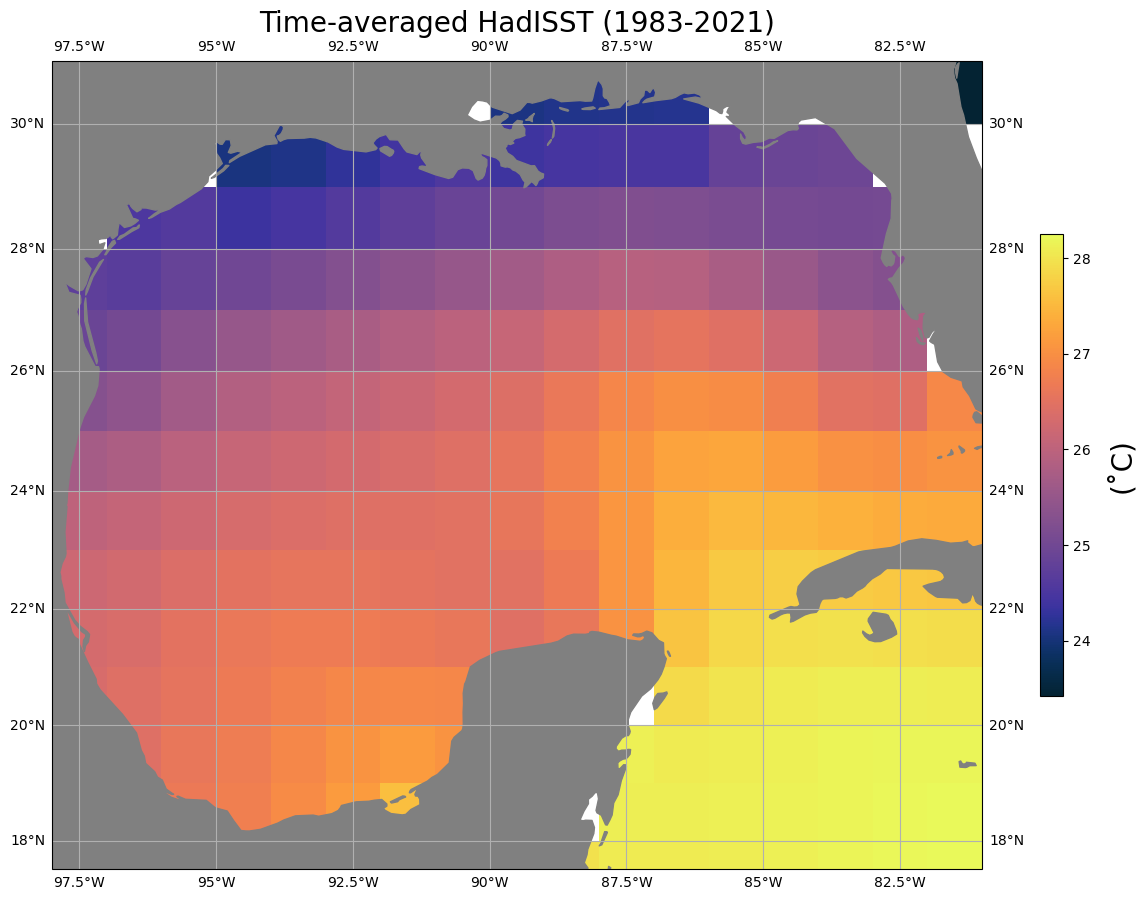

In [10]:
plot_mean(hadisst83, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='HadISST (1983-2021)', var_name='hadisst83', pcmdi=False)

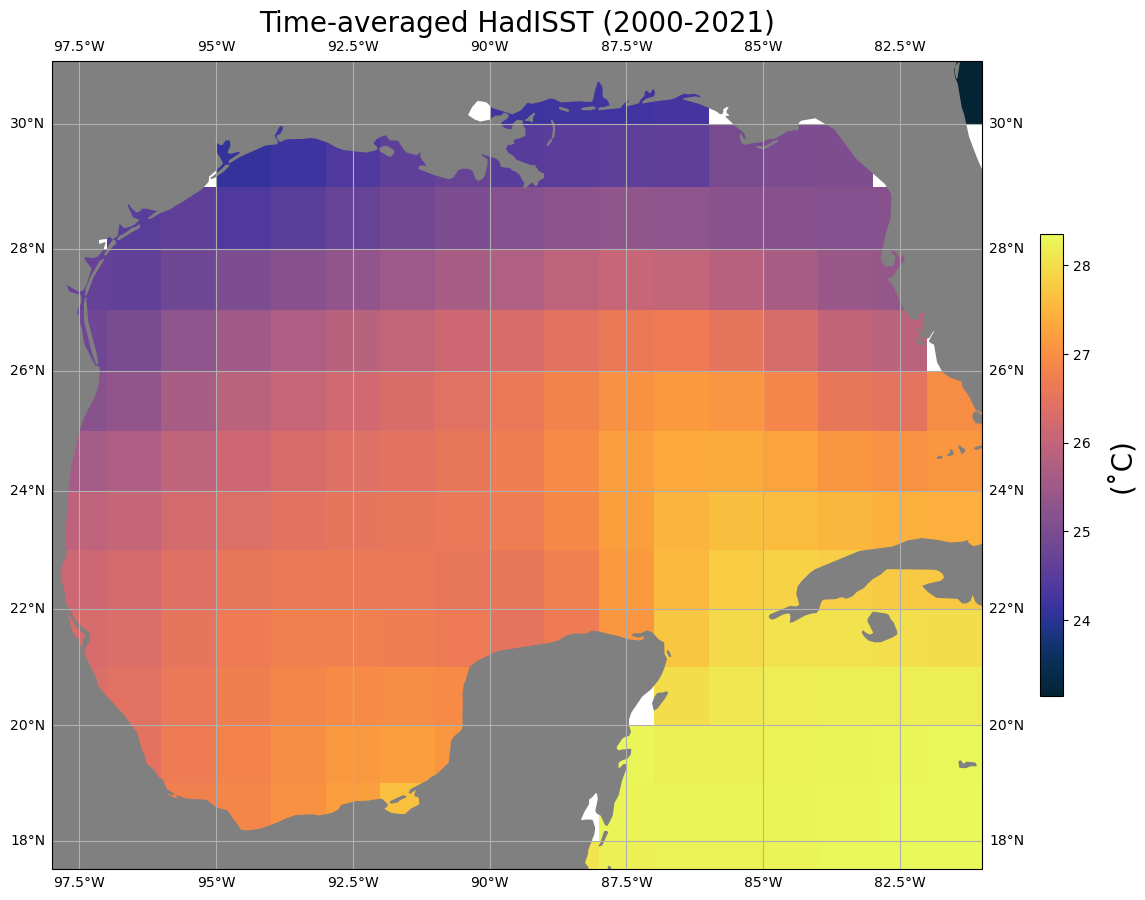

In [11]:
plot_mean(hadisst20, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='HadISST (2000-2021)', var_name='hadisst20', pcmdi=False)

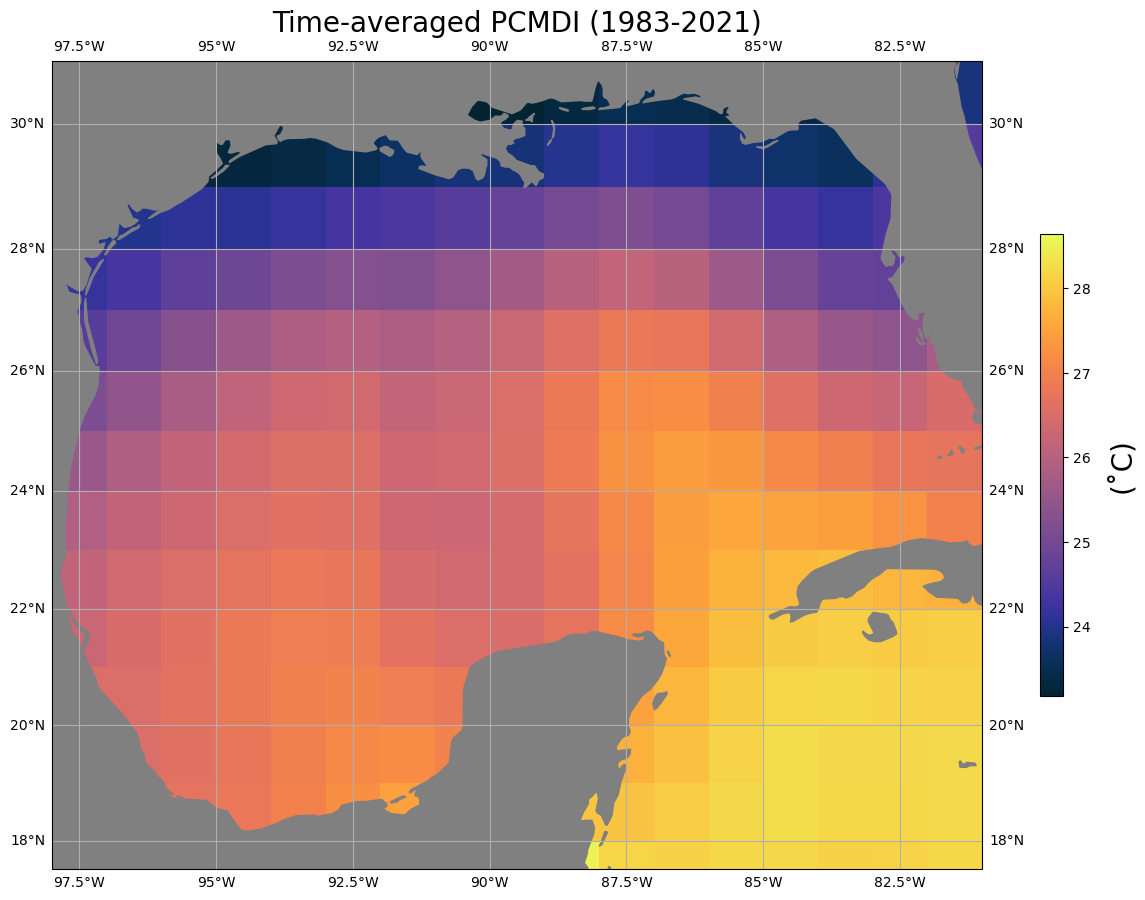

In [12]:
plot_mean(pcmdi83, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='PCMDI (1983-2021)', var_name='pcmdi83', pcmdi=True)

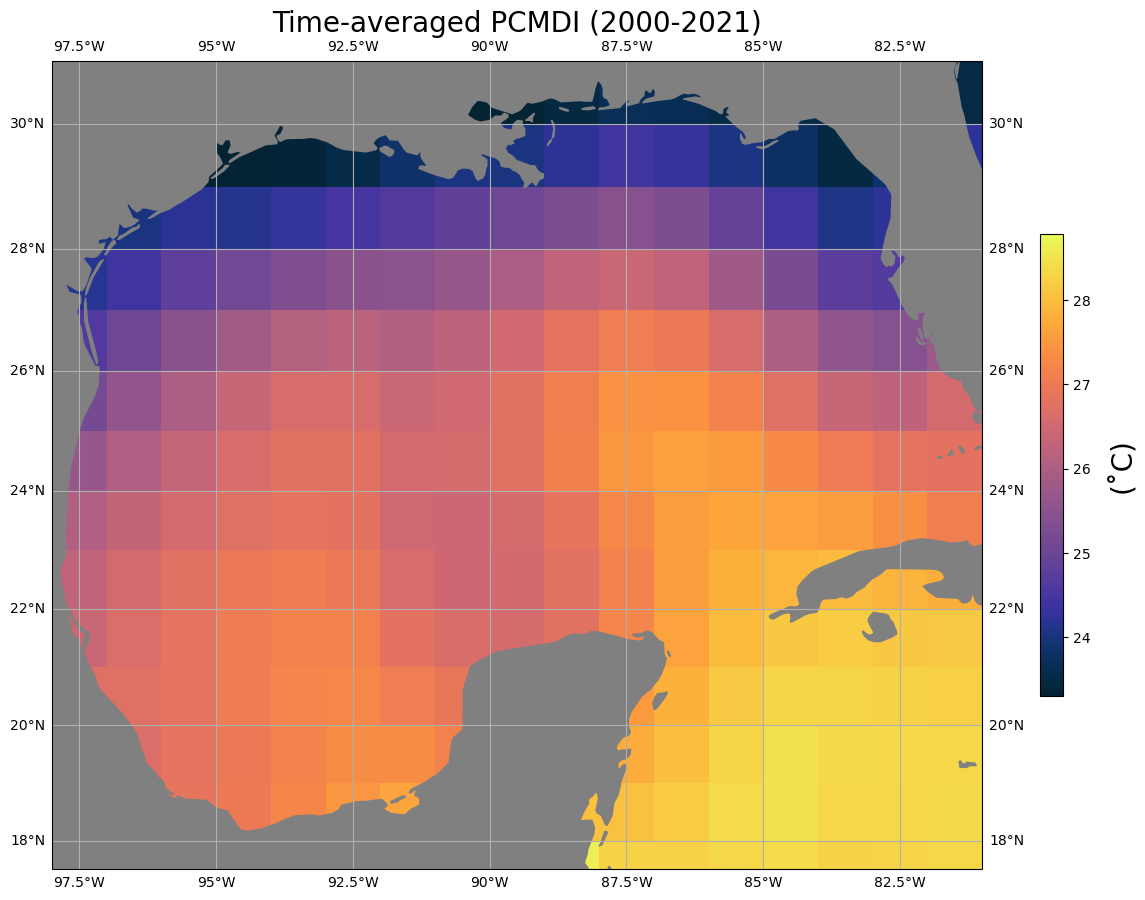

In [13]:
plot_mean(pcmdi20, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='PCMDI (2000-2021)', var_name='pcmdi20', pcmdi=True)

## Calculate linear trend for each data field

In [14]:
#linear regression at every grid cell over time, so that we see trend rate at each grid pt
# Calculate the linear trend at each grid point
def trending(da):
    d = da.groupby('time.year').mean('time').polyfit('year', deg=1, skipna=True, cov=True)

    return d

In [15]:
trend_hadisst83 = trending(hadisst83)
trend_hadisst20 = trending(hadisst20)
trend_pcmdi83 = trending(pcmdi83)
trend_pcmdi20 = trending(pcmdi20)

## Trends (spatial maps)

In [16]:
def plot_trend(da, title, var_title, cbar_label, v_min, v_max, cmap_choice, pcmdi=True):
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))
    
    ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
    if pcmdi==False:
        d = da.polyfit_coefficients[0]
        norm = TwoSlopeNorm(vmin=v_min, vcenter=0, vmax=v_max)
        im = ax.pcolormesh(d.longitude, d.latitude, d, transform=ccrs.PlateCarree(), 
                           norm=norm, cmap=cmap_choice)
        cb = fig.colorbar(im, ax=ax, shrink=0.4)
        cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
        
        g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        g1.xlabels_top = False
        g1.ylabels_right = False
        
        plt.title(f'{title}', fontsize=26);
    else:
        d = da.polyfit_coefficients[0]
        im = ax.pcolormesh(d.lon, d.lat, d, transform=ccrs.PlateCarree(), 
                           vmin=v_min, vmax=v_max, cmap=cmap_choice)#norm=LogNorm(),
        cb = fig.colorbar(im, ax=ax, shrink=0.4)
        cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
        
        g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        g1.xlabels_top = False
        g1.ylabels_right = False
        
        plt.title(f'{title}', fontsize=26)
    plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/Obs/trend/trend_spatio_{var_title}.pdf');

In [17]:
print('Max: ', trend_hadisst83.polyfit_coefficients[0].max().values, 'C/yr', 
      '\nMin: ', trend_hadisst83.polyfit_coefficients[0].min().values, 'C/yr')

Max:  0.01833435282533515 C/yr 
Min:  -0.02993142054631205 C/yr


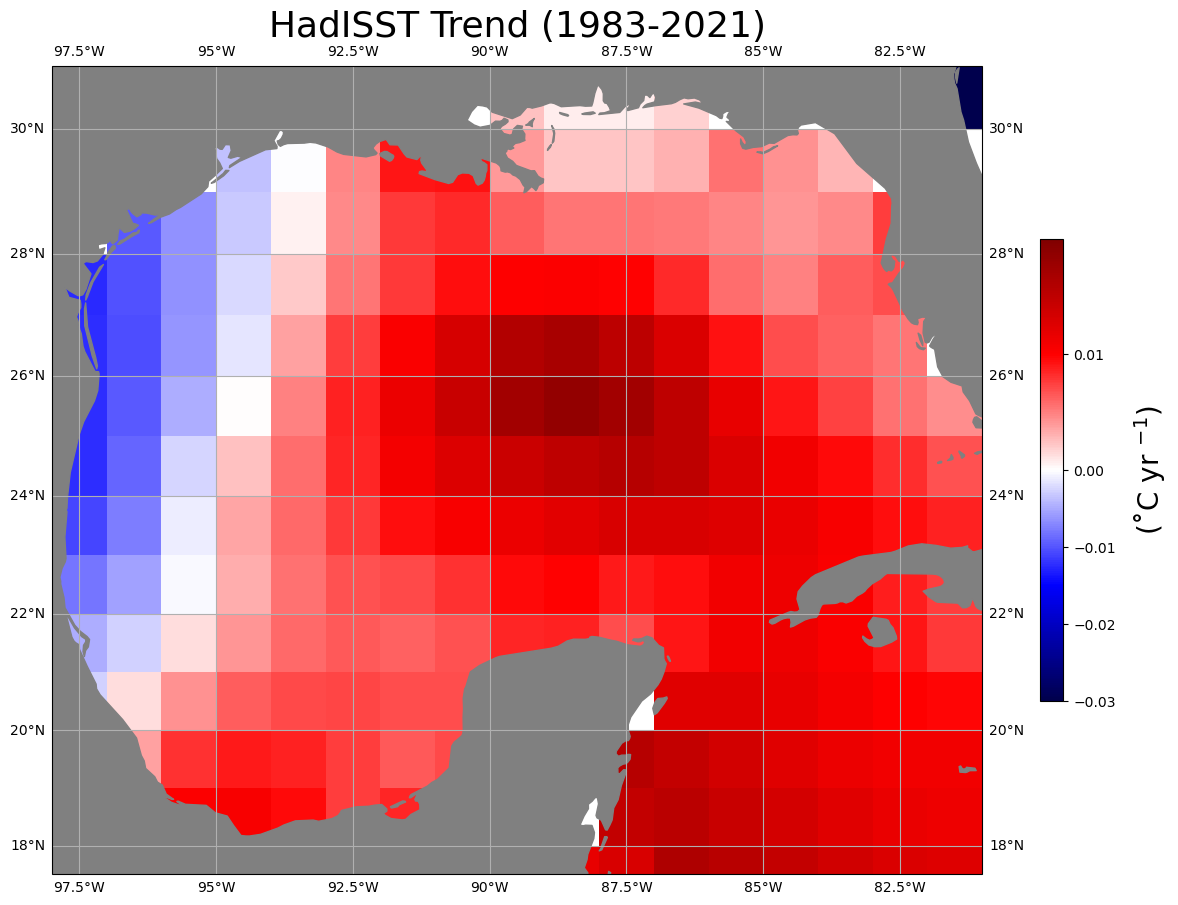

In [18]:
plot_trend(trend_hadisst83, 'HadISST Trend (1983-2021)', 'hadISST83', '(˚C yr $^{-1}$)', 
           -0.03, 0.02, cmap_choice='seismic', pcmdi=False)

In [19]:
print('Max: ', trend_hadisst20.polyfit_coefficients[0].max().values, 'C/yr', 
      '\nMin: ', trend_hadisst20.polyfit_coefficients[0].min().values, 'C/yr')

Max:  0.02023062552522697 C/yr 
Min:  -0.0320478285321525 C/yr


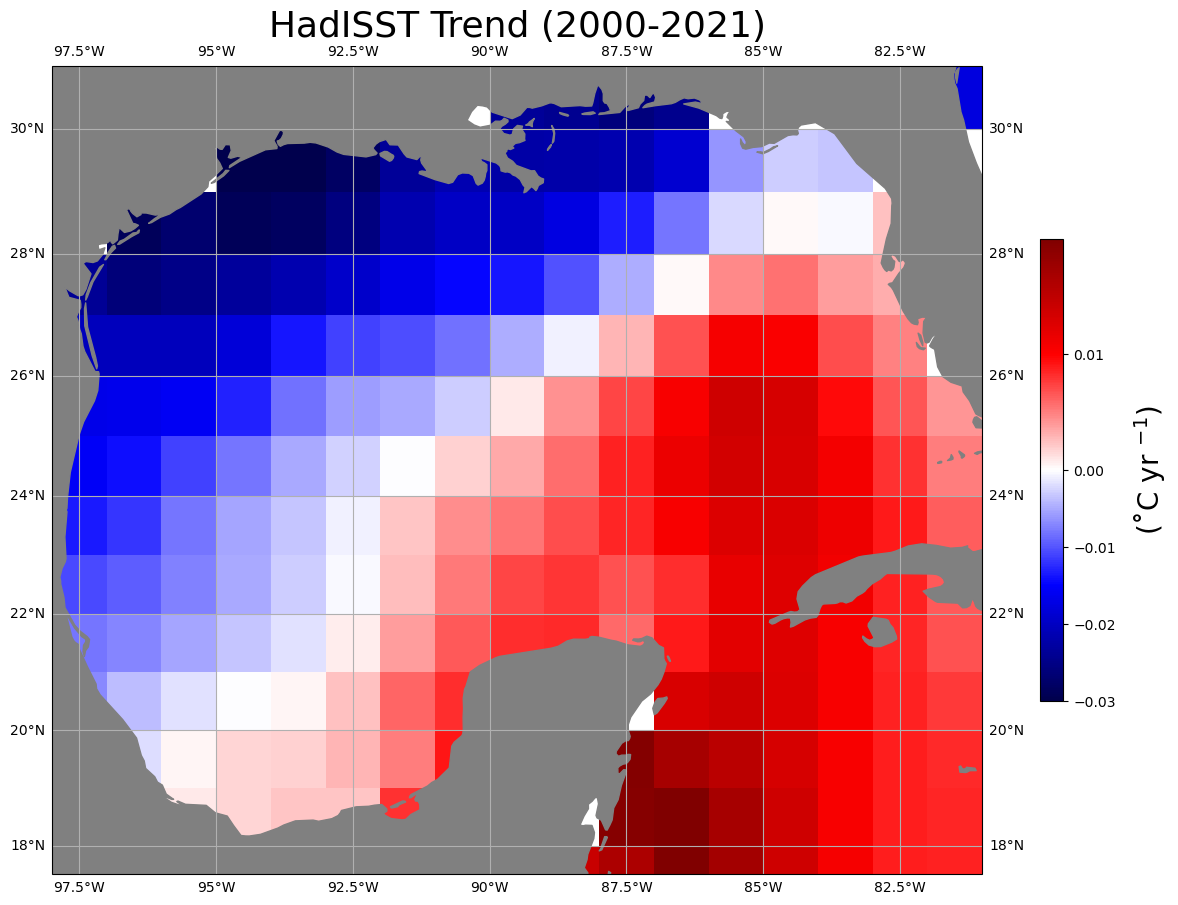

In [20]:
plot_trend(trend_hadisst20, 'HadISST Trend (2000-2021)', 'hadISST20', '(˚C yr $^{-1}$)', 
           -0.03, 0.02, cmap_choice='seismic', pcmdi=False)

In [22]:
print('Max: ', trend_pcmdi83.polyfit_coefficients[0].max().values, 'C/yr', 
      '\nMin: ', trend_pcmdi83.polyfit_coefficients[0].min().values, 'C/yr')

Max:  0.026899530820036332 C/yr 
Min:  -0.04714391106053435 C/yr


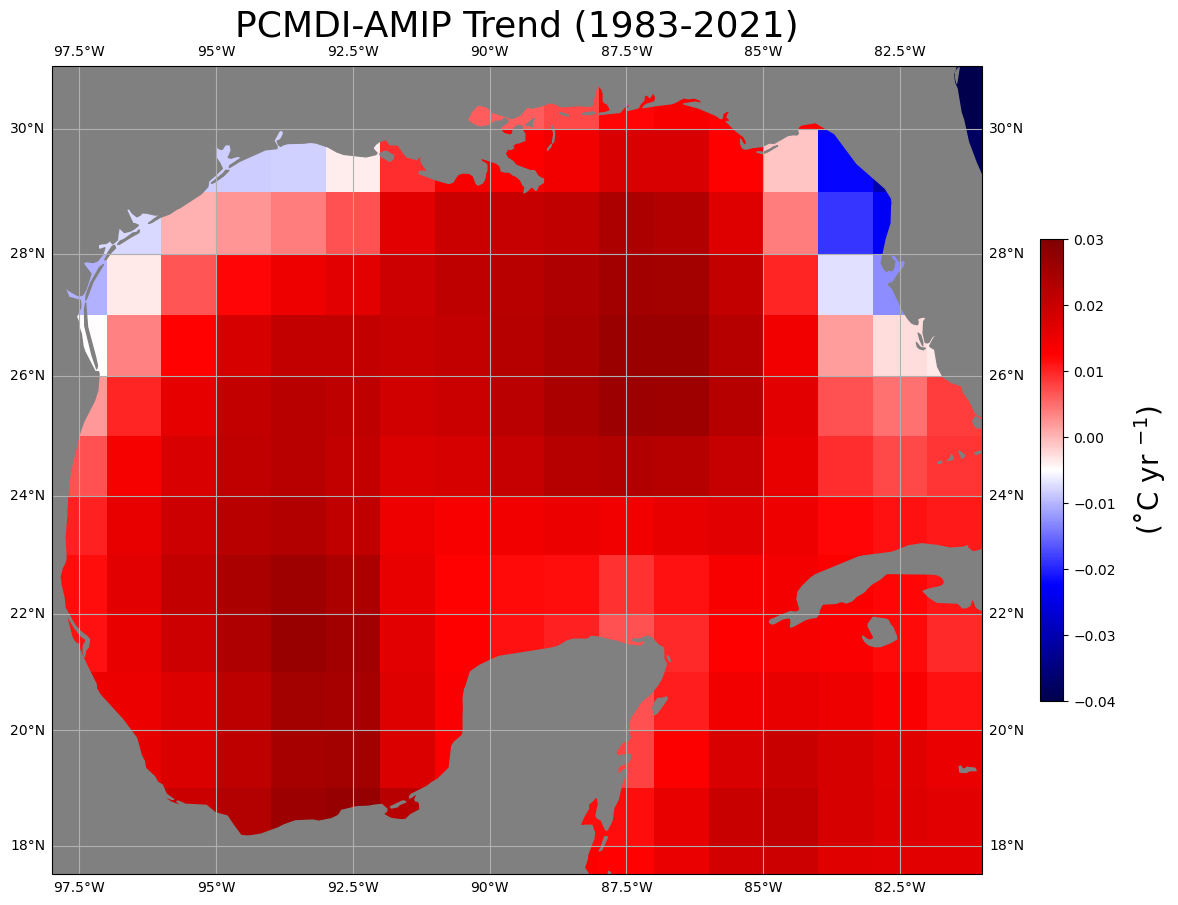

In [25]:
plot_trend(trend_pcmdi83, 'PCMDI-AMIP Trend (1983-2021)', 'pcmdi83', '(˚C yr $^{-1}$)', 
           -0.04, 0.03, cmap_choice='seismic')

In [23]:
print('Max: ', trend_pcmdi20.polyfit_coefficients[0].max().values, 'C/yr', 
      '\nMin: ', trend_pcmdi20.polyfit_coefficients[0].min().values, 'C/yr')

Max:  0.03481186964227752 C/yr 
Min:  -0.033306981263895176 C/yr


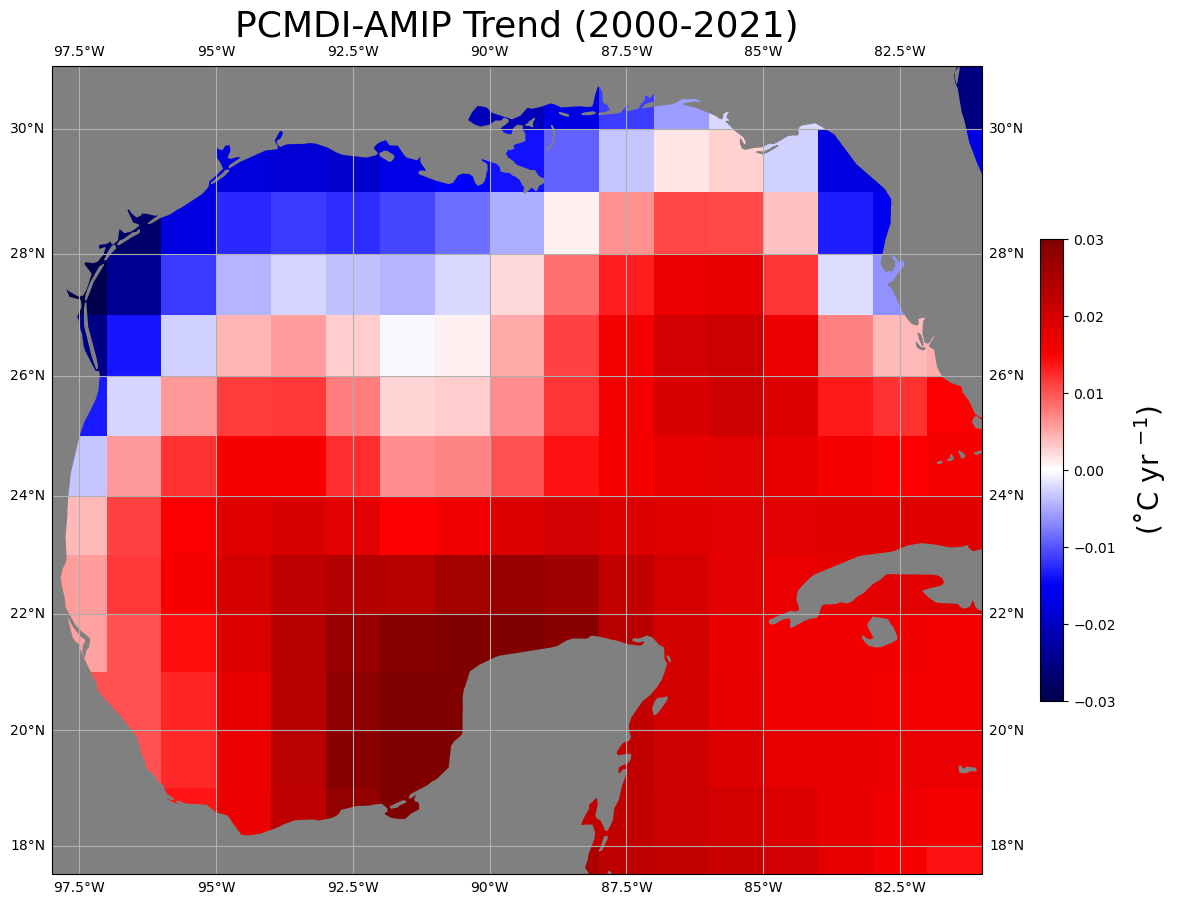

In [24]:
plot_trend(trend_pcmdi20, 'PCMDI-AMIP Trend (2000-2021)', 'pcmdi20', '(˚C yr $^{-1}$)', 
           -0.03, 0.03, cmap_choice='seismic')

# CERES 
(dir: `/work/rjk/data/CERES/EBAF-All`)

In [26]:
ceres_ds = xr.open_dataset('/work/rjk/data/CERES/EBAF-All/CERES_EBAF_Ed4.2_Subset_200003-202312.nc', chunks={})

In [27]:
gom = dict(lat=slice(17.5,31), lon=slice(261,281), time=slice(None, '2021-06-30'))
ceres = ceres_ds.sel(**gom)

In [28]:
ceres

<xarray.Dataset> Size: 9MB
Dimensions:                (time: 256, lon: 20, lat: 14)
Coordinates:
  * time                   (time) datetime64[ns] 2kB 2000-03-15 ... 2021-06-15
  * lon                    (lon) float32 80B 261.5 262.5 263.5 ... 279.5 280.5
  * lat                    (lat) float32 56B 17.5 18.5 19.5 ... 28.5 29.5 30.5
Data variables: (12/31)
    toa_sw_all_mon         (time, lat, lon) float32 287kB dask.array<chunksize=(256, 14, 20), meta=np.ndarray>
    toa_lw_all_mon         (time, lat, lon) float32 287kB dask.array<chunksize=(256, 14, 20), meta=np.ndarray>
    toa_net_all_mon        (time, lat, lon) float32 287kB dask.array<chunksize=(256, 14, 20), meta=np.ndarray>
    toa_sw_clr_c_mon       (time, lat, lon) float32 287kB dask.array<chunksize=(256, 14, 20), meta=np.ndarray>
    toa_lw_clr_c_mon       (time, lat, lon) float32 287kB dask.array<chunksize=(256, 14, 20), meta=np.ndarray>
    toa_net_clr_c_mon      (time, lat, lon) float32 287kB dask.array<chunksize=(256, 14, 20), meta=np.ndarray>
    ...                     ...
    sfc_net_lw_all_mon     (time, lat, lon) float32 287kB dask.array<chunksize=(256, 14, 20), meta=np.ndarray>
    sfc_net_lw_clr_c_mon   (time, lat, lon) float32 287kB dask.array<chunksize=(256, 14, 20), meta=np.ndarray>
    sfc_net_lw_clr_t_mon   (time, lat, lon) float32 287kB dask.array<chunksize=(256, 14, 20), meta=np.ndarray>
    sfc_net_tot_all_mon    (time, lat, lon) float32 287kB dask.array<chunksize=(256, 14, 20), meta=np.ndarray>
    sfc_net_tot_clr_c_mon  (time, lat, lon) float32 287kB dask.array<chunksize=(256, 14, 20), meta=np.ndarray>
    sfc_net_tot_clr_t_mon  (time, lat, lon) float32 287kB dask.array<chunksize=(256, 14, 20), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.4
    institution:  NASA Langley Research Center
    title:        CERES EBAF TOA and Surface Fluxes. Monthly Averages and 07/...
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.2; Revised data Release Date January 2, 2024
    DOI:          10.5067/TERRA-AQUA-NOAA20/CERES/EBAF_L3B004.2
    history:      Wed May 01 23:30:25 2024: cdo cat CERES_EBAF_Ed4.2_Subset_2...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [29]:
#sfc_sw_down_all - sfc_sw_up_all = sfc_net_sw_all
sw = ceres.sfc_net_sw_all_mon - ceres.toa_sw_all_mon
lw = ceres.sfc_net_lw_all_mon - ceres.toa_lw_all_mon

## Plot time average of the fields

In [32]:
def plot_mean(da, cmap_choice, cbar_label, var_name, quiver=True):
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))
    ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
    im = ax.pcolormesh(da.lon, da.lat, da.mean('time'), transform=ccrs.PlateCarree(), cmap=cmap_choice)
    cb = fig.colorbar(im, ax=ax, shrink=0.4)
    cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
    g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    g1.xlabels_top = False
    g1.ylabels_right = False
    plt.title(f'Time-averaged CERES {var_name} (2000-2021)', fontsize=20)
    plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/Obs/time-mean/time-mean_{var_name}.pdf');        

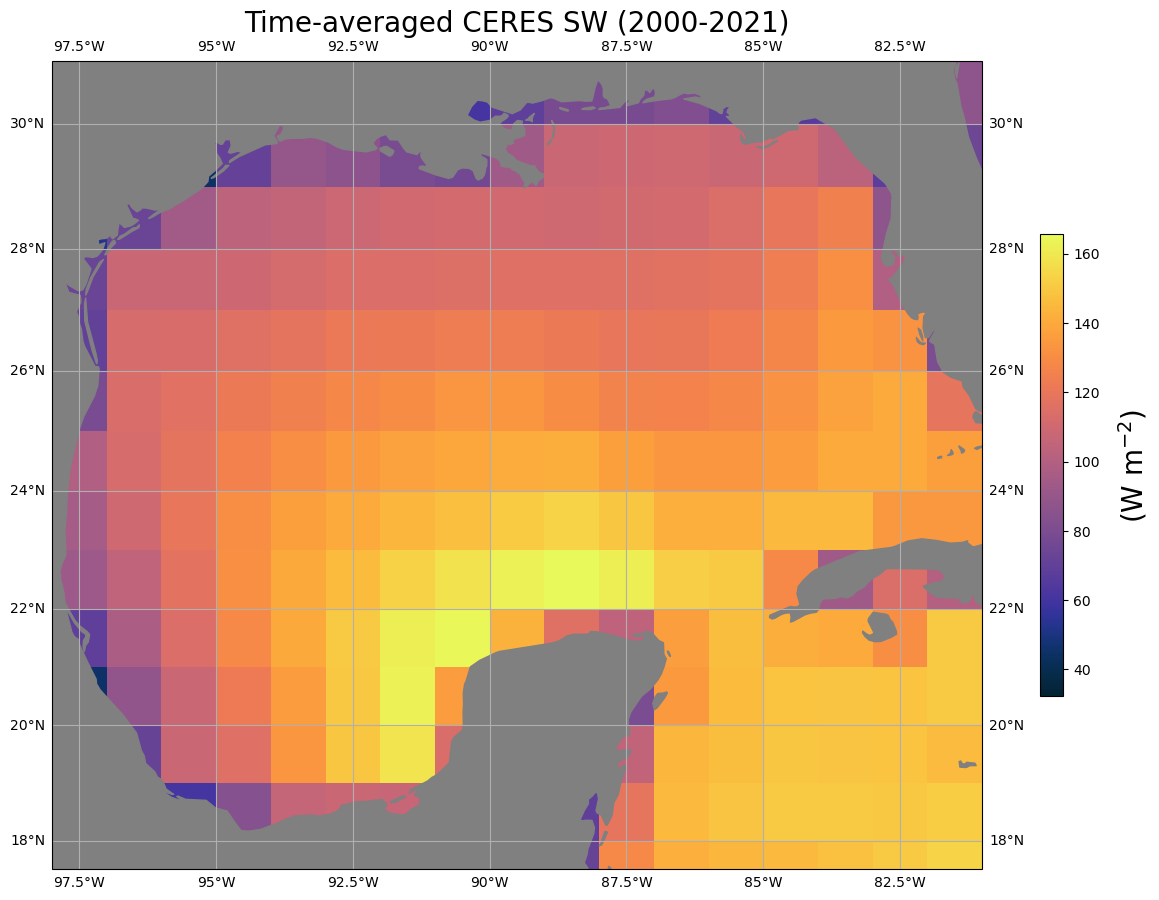

In [33]:
plot_mean(sw, cmap_choice=cmocean.cm.thermal, cbar_label=r'(W m$^{-2}$)', 
          var_name='SW')

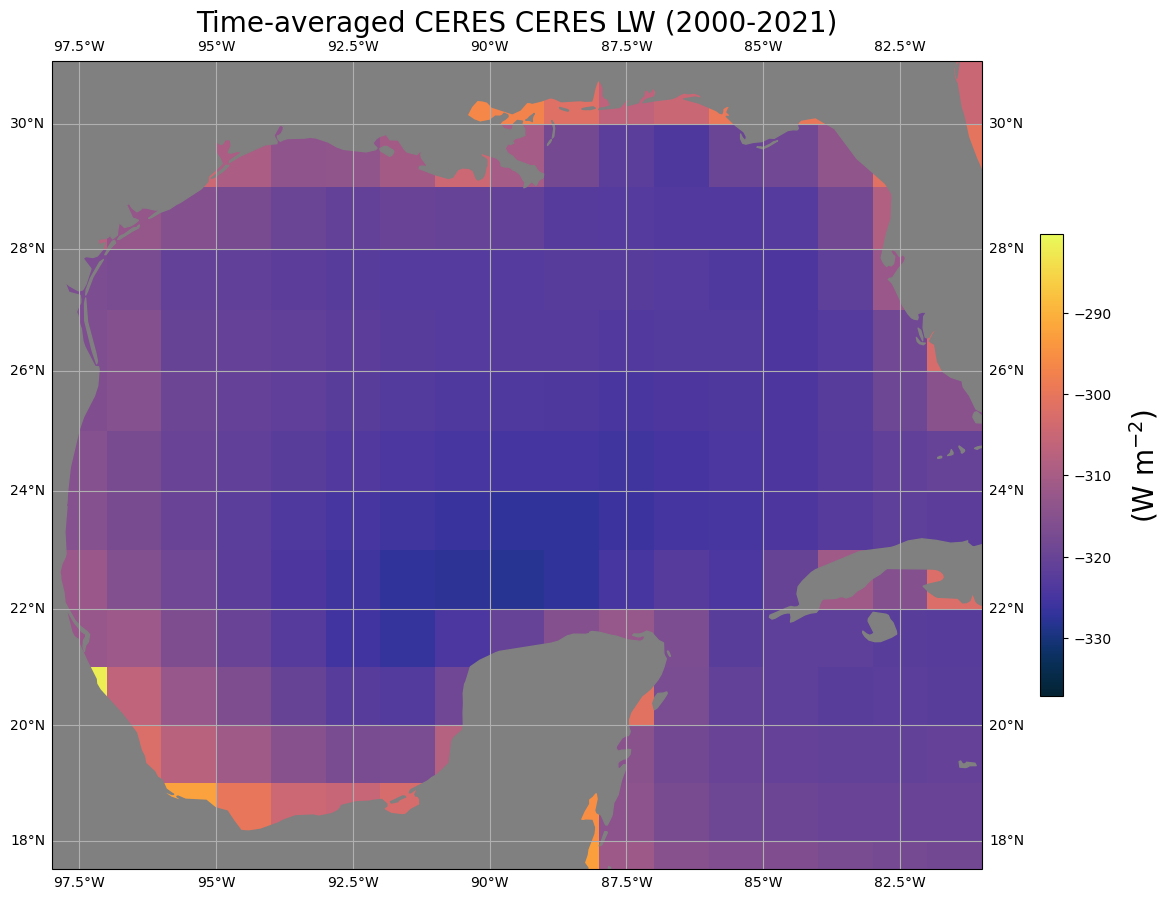

In [34]:
plot_mean(lw, cmap_choice=cmocean.cm.thermal, cbar_label=r'(W m$^{-2}$)', 
          var_name='CERES LW')

## Calculate linear trend for each data field

In [35]:
#linear regression at every grid cell over time, so that we see trend rate at each grid pt
# Calculate the linear trend at each grid point
def trending(da):
    d = da.groupby('time.year').mean('time').polyfit('year', deg=1, skipna=True, cov=True)

    return d

In [36]:
trend_lw = trending(lw)
trend_sw = trending(sw)

## Trends (spatial maps)

In [37]:
def plot_trend(da, title, var_title, cbar_label, v_min, v_max, cmap_choice, diverge=True):
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))
    
    ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
    if diverge==True:
        d = da.polyfit_coefficients[0]
        norm = TwoSlopeNorm(vmin=v_min, vcenter=0, vmax=v_max)
        im = ax.pcolormesh(d.lon, d.lat, d, transform=ccrs.PlateCarree(), 
                           norm=norm, cmap=cmap_choice)
        cb = fig.colorbar(im, ax=ax, shrink=0.4)
        cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
        
        g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        g1.xlabels_top = False
        g1.ylabels_right = False
        
        plt.title(f'{title}', fontsize=26);
    else:
        d = da.polyfit_coefficients[0]
        im = ax.pcolormesh(d.lon, d.lat, d, transform=ccrs.PlateCarree(), 
                           vmin=v_min, vmax=v_max, cmap=cmap_choice)#norm=LogNorm(),
        cb = fig.colorbar(im, ax=ax, shrink=0.4)
        cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
        
        g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        g1.xlabels_top = False
        g1.ylabels_right = False
        
        plt.title(f'{title}', fontsize=26)
    plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/Obs/trend/trend_spatio_{var_title}.pdf');

In [38]:
print('Max: ', trend_lw.polyfit_coefficients[0].max().values, 'W/m2/yr', 
      '\nMin: ', trend_lw.polyfit_coefficients[0].min().values, 'W/m2/yr')

Max:  0.5469404982012692 W/m2/yr 
Min:  -0.365676785107722 W/m2/yr


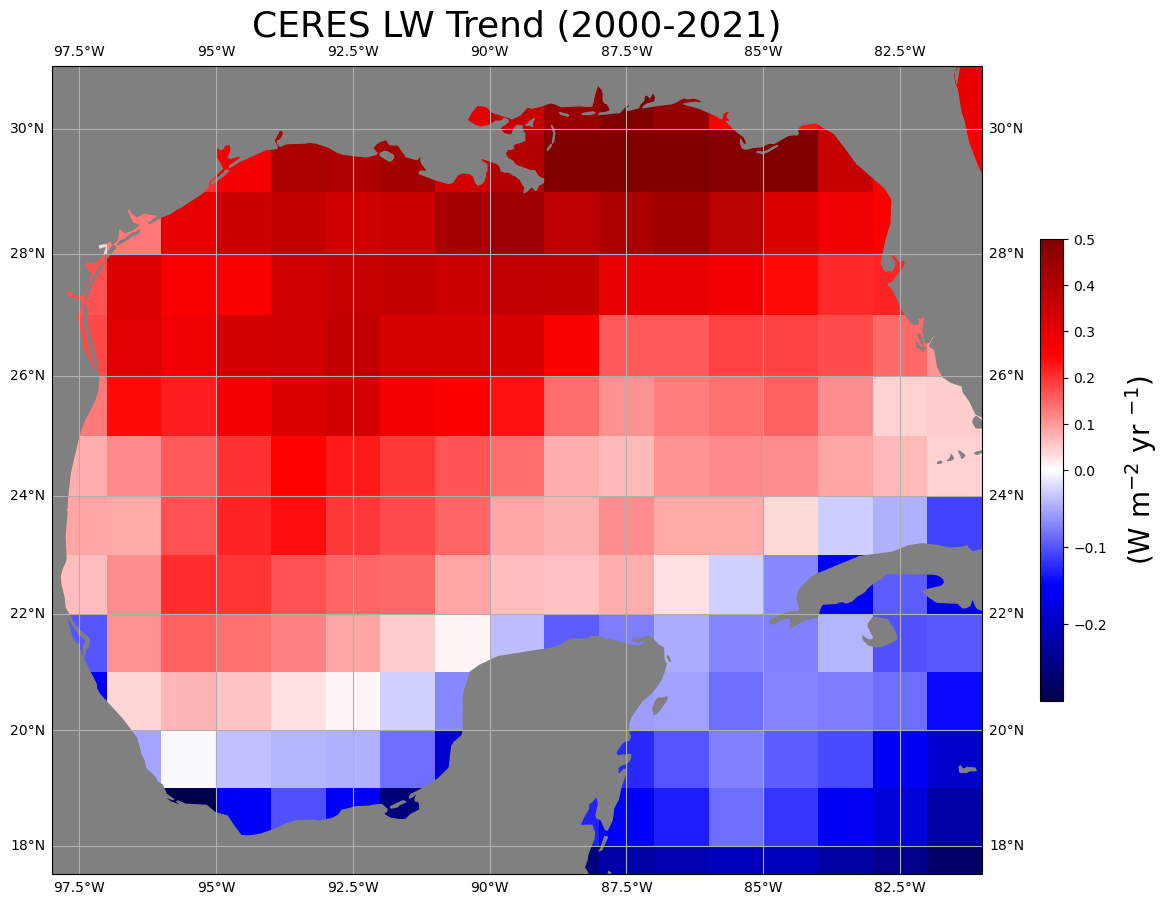

In [39]:
plot_trend(trend_lw, 'CERES LW Trend (2000-2021)', 'LW', '(W m$^{-2}$ yr $^{-1}$)', 
           -0.3, 0.5, cmap_choice='seismic')

In [40]:
print('Max: ', trend_sw.polyfit_coefficients[0].max().values, 'W/m2/yr', 
      '\nMin: ', trend_sw.polyfit_coefficients[0].min().values, 'W/m2/yr')

Max:  0.811501126582812 W/m2/yr 
Min:  -0.9422240900764515 W/m2/yr


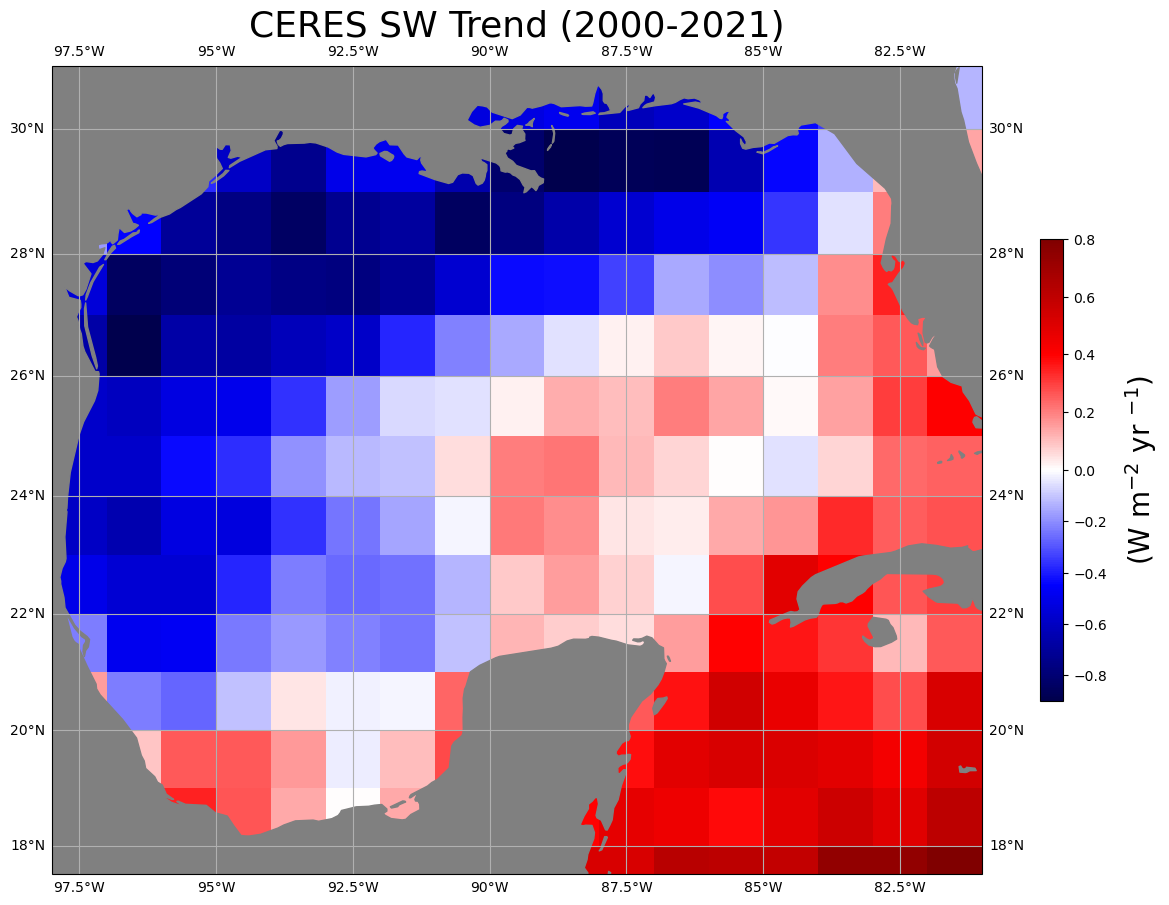

In [41]:
plot_trend(trend_sw, 'CERES SW Trend (2000-2021)', 'SW', '(W m$^{-2}$ yr $^{-1}$)', 
           -0.9, 0.8, cmap_choice='seismic')

# [OISST](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html) 
(need to confirm if this is (AMSR)+AVHRR or just AVHRR, i think it's the former)

In [88]:
oisst_ds = xr.open_dataset('sst.mon.mean.nc', chunks={})
gom83 = dict(lat=slice(17.5,31.15), lon=slice(261,281), time=slice('1983', '2021-06-30'))
gom20 = dict(lat=slice(17.5,31.15), lon=slice(261,281), time=slice('2000', '2021-06-30'))

oisst83 = oisst_ds.sst.sel(**gom83)
oisst20 = oisst_ds.sst.sel(**gom20)

In [50]:
oisst83

<xarray.DataArray 'sst' (time: 462, lat: 55, lon: 80)> Size: 8MB
dask.array<getitem, shape=(462, 55, 80), dtype=float32, chunksize=(1, 55, 80), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 4kB 1983-01-01 1983-02-01 ... 2021-06-01
  * lat      (lat) float32 220B 17.62 17.88 18.12 18.38 ... 30.62 30.88 31.12
  * lon      (lon) float32 320B 261.1 261.4 261.6 261.9 ... 280.4 280.6 280.9
Attributes:
    long_name:      Monthly Mean of Sea Surface Temperature
    units:          degC
    valid_range:    [-3. 45.]
    precision:      2.0
    dataset:        NOAA High-resolution Blended Analysis
    var_desc:       Sea Surface Temperature
    level_desc:     Surface
    statistic:      Monthly Mean
    parent_stat:    Individual Observations
    actual_range:   [-1.8  32.14]
    standard_name:  sea_surface_temperature

## Plot time average of the fields

In [51]:
def plot_mean(da, cmap_choice, cbar_label, yr_start, var_name, quiver=True):
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))
    ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
    im = ax.pcolormesh(da.lon, da.lat, da.mean('time'), transform=ccrs.PlateCarree(), cmap=cmap_choice)
    cb = fig.colorbar(im, ax=ax, shrink=0.4)
    cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
    g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    g1.xlabels_top = False
    g1.ylabels_right = False
    plt.title(f'Time-averaged OISST ({yr_start}-2021)', fontsize=20)
    plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/Obs/time-mean/time-mean_{var_name}.pdf');        

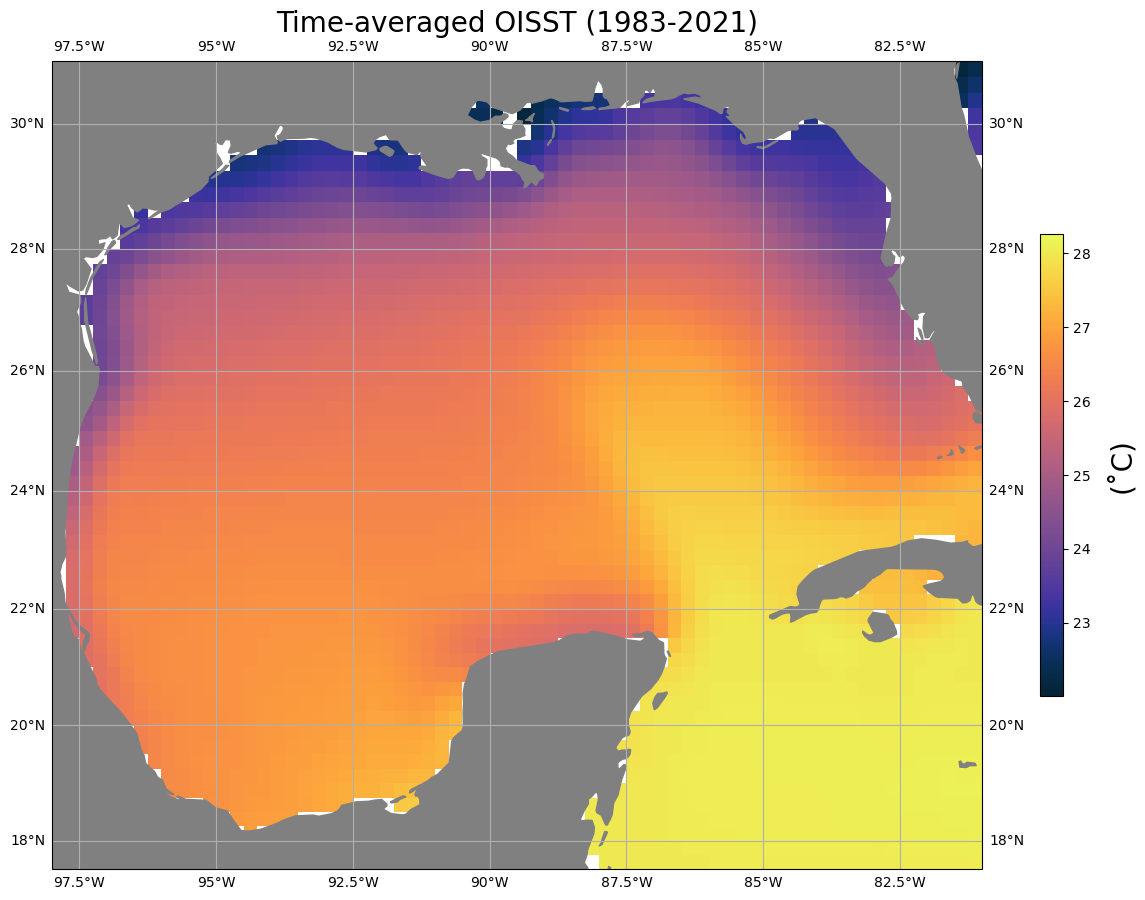

In [52]:
plot_mean(oisst83, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          yr_start='1983', var_name='oisst83')

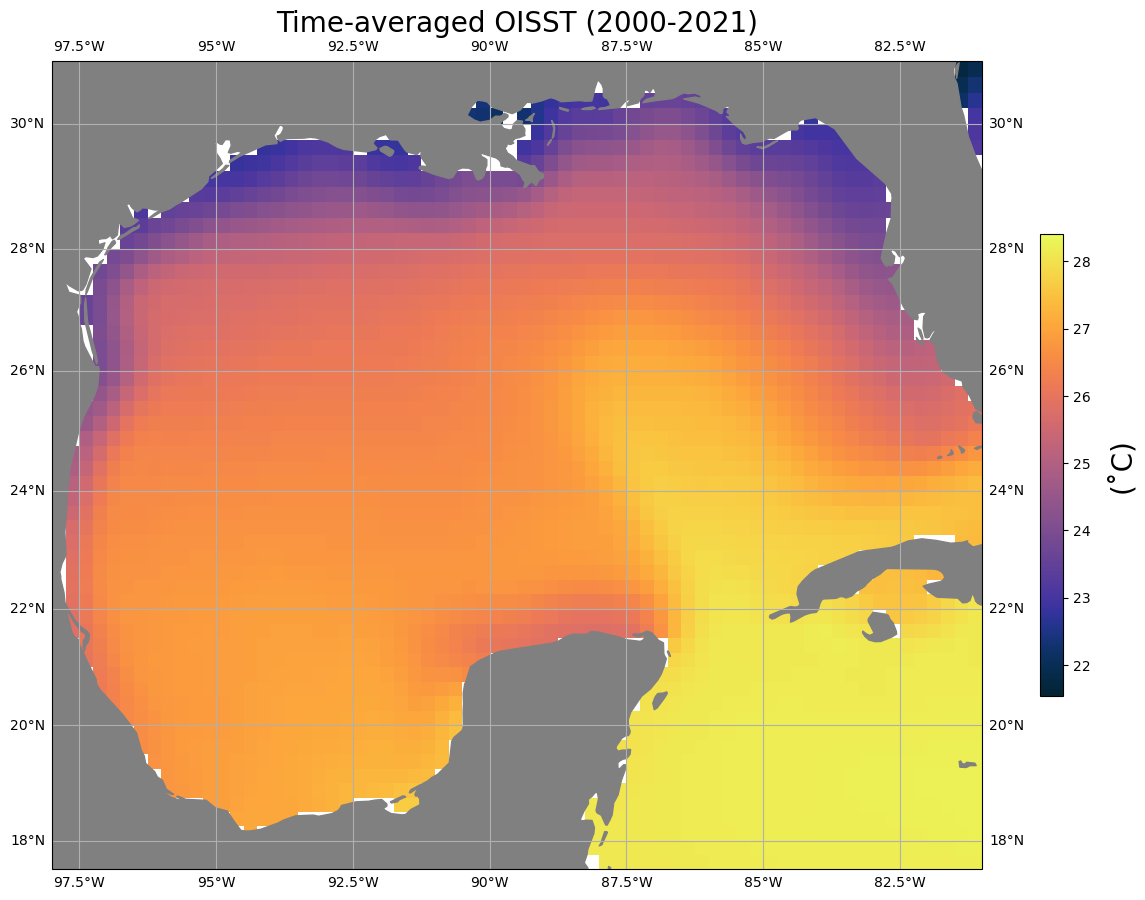

In [53]:
plot_mean(oisst20, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          yr_start='2000', var_name='oisst20')

## Calculate linear trend for each data field

In [54]:
#linear regression at every grid cell over time, so that we see trend rate at each grid pt
# Calculate the linear trend at each grid point
def trending(da):
    d = da.groupby('time.year').mean('time').polyfit('year', deg=1, skipna=True, cov=True)

    return d

In [55]:
trend_oisst83 = trending(oisst83)
trend_oisst20 = trending(oisst20)

## Trends (spatial maps)

In [59]:
def plot_trend(da, title, var_title, cbar_label, v_min, v_max, cmap_choice):
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))
    
    ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
    d = da.polyfit_coefficients[0]
    im = ax.pcolormesh(d.lon, d.lat, d, transform=ccrs.PlateCarree(), 
                       vmin=v_min, vmax=v_max, cmap=cmap_choice)#norm=LogNorm(),
    cb = fig.colorbar(im, ax=ax, shrink=0.4)
    cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
    
    g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    g1.xlabels_top = False
    g1.ylabels_right = False
    
    plt.title(f'{title}', fontsize=26)
    plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/Obs/trend/trend_spatio_{var_title}.pdf');

In [60]:
print('Max: ', trend_oisst83.polyfit_coefficients[0].max().values, '˚C/yr', 
      '\nMin: ', trend_oisst83.polyfit_coefficients[0].min().values, '˚C/yr')

Max:  0.032854535801690704 ˚C/yr 
Min:  -0.049295191050542204 ˚C/yr


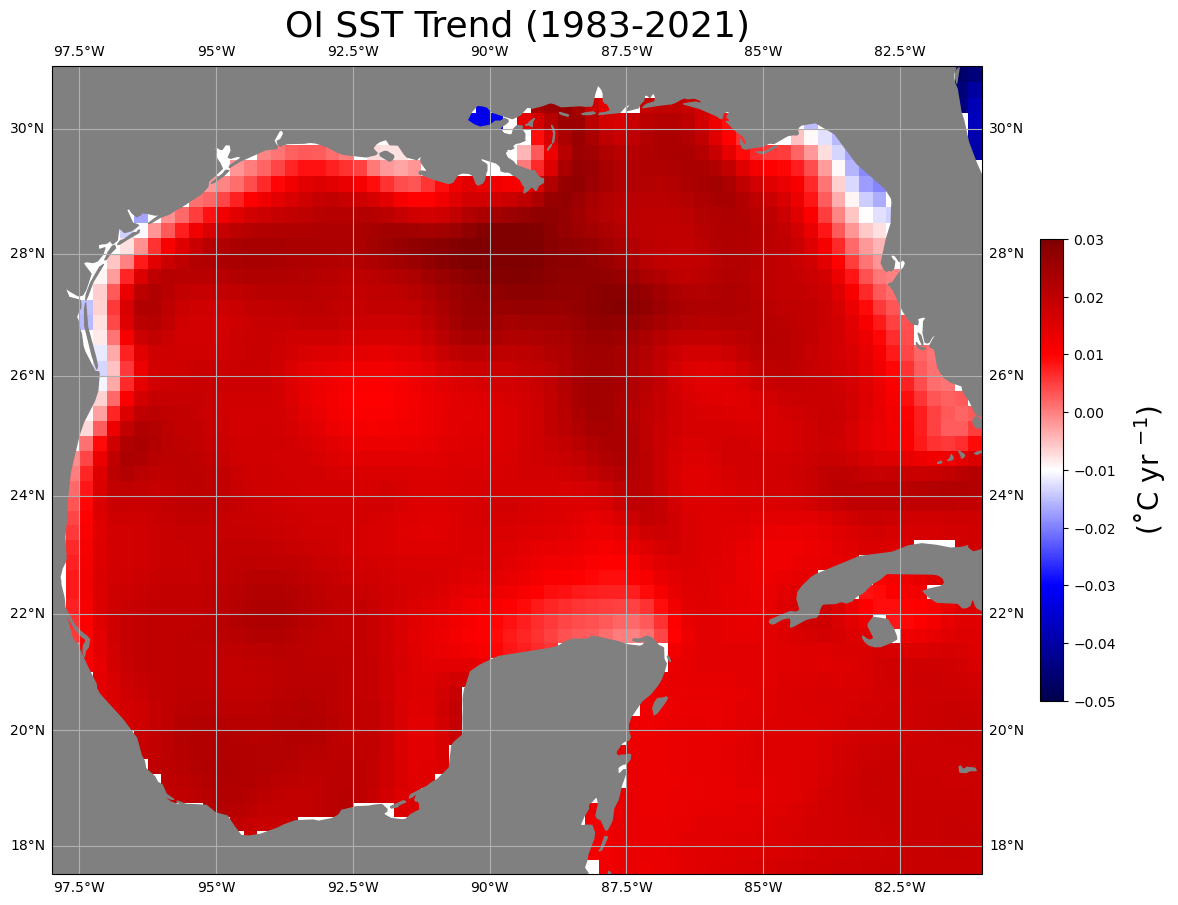

In [61]:
plot_trend(trend_oisst83, 'OI SST Trend (1983-2021)', 'oisst83', '(˚C yr $^{-1}$)', 
           -0.05, 0.03, cmap_choice='seismic')

In [62]:
print('Max: ', trend_oisst20.polyfit_coefficients[0].max().values, '˚C/yr', 
      '\nMin: ', trend_oisst20.polyfit_coefficients[0].min().values, '˚C/yr')

Max:  0.06862339793053604 ˚C/yr 
Min:  -0.1023910518152938 ˚C/yr


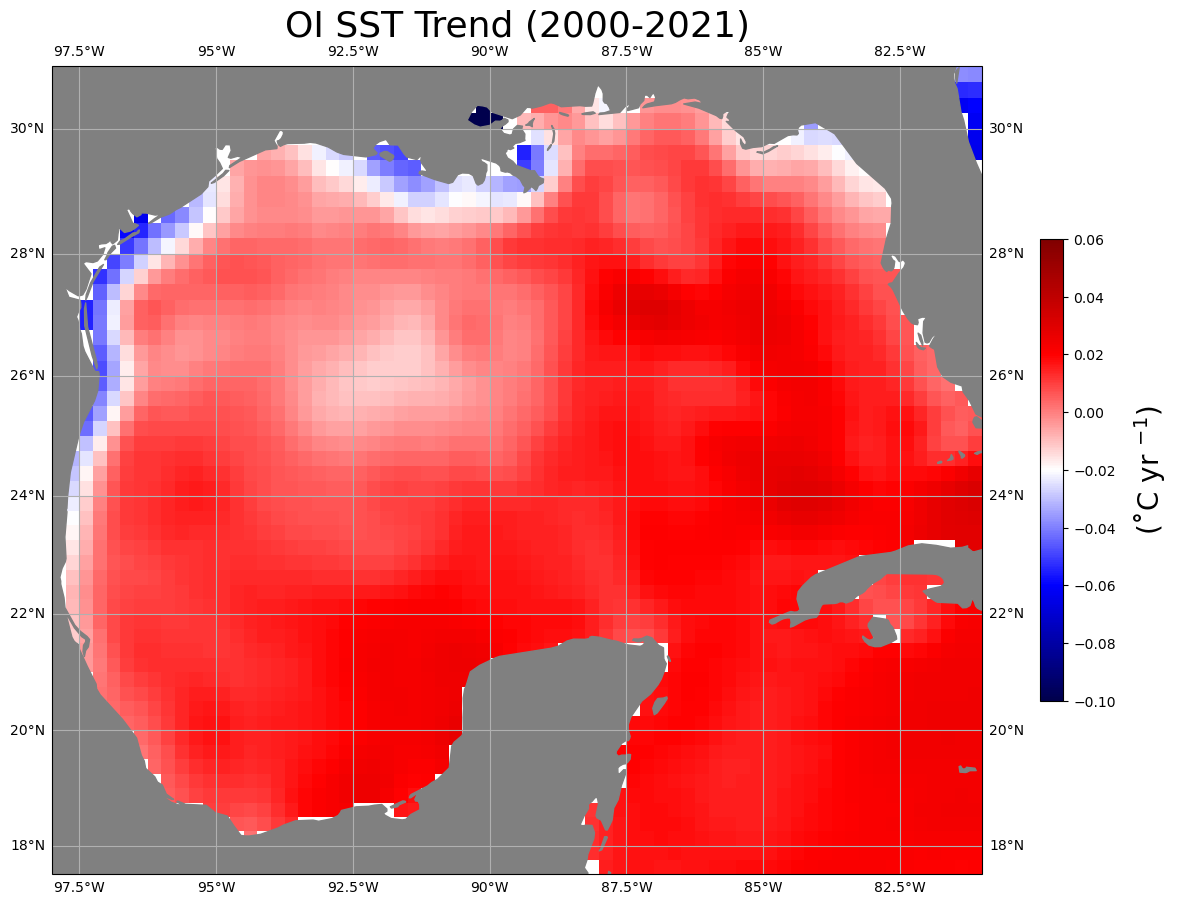

In [64]:
plot_trend(trend_oisst20, 'OI SST Trend (2000-2021)', 'oisst20', '(˚C yr $^{-1}$)', 
           -0.1, 0.06, cmap_choice='seismic')

# Trends (basin-average)

## Calculate trend lines

In [72]:
def trending(da, da_name, lat=True):
    if lat==True:
        d = {}
        d[f'{da_name}_trend_lr'] = linregress(np.arange(0, da.time.size), da.mean(['lat', 'lon']))#.fillna(0.))
        d[f'{da_name}_trend_line_lr'] = (d[f'{da_name}_trend_lr'][0]*np.arange(0,da.time.size) 
                                         + d[f'{da_name}_trend_lr'][1])
    else:
        d = {}
        d[f'{da_name}_trend_lr'] = linregress(np.arange(0, da.time.size), da.mean(['latitude', 'longitude']))#.fillna(0.))
        d[f'{da_name}_trend_line_lr'] = (d[f'{da_name}_trend_lr'][0]*np.arange(0,da.time.size) 
                                     + d[f'{da_name}_trend_lr'][1])

    return d

In [97]:
trend_dict_hadisst83 = trending(hadisst83, hadisst83.name, lat=False)
trend_dict_hadisst20 = trending(hadisst20, hadisst20.name, lat=False)
trend_dict_pcmdi83 = trending(pcmdi83, pcmdi83.name)
trend_dict_pcmdi20 = trending(pcmdi20, pcmdi20.name)                   

trend_dict_sw = trending(sw, 'sw')
trend_dict_lw = trending(lw, 'lw')

trend_dict_oisst83 = trending(oisst83, oisst83.name)
trend_dict_oisst20 = trending(oisst20, oisst20.name)

In [133]:
float(trend_dict_hadisst83['sst_trend_lr'][0])

0.0009730238890910911

In [134]:
trend_dict_hadisst83['sst_trend_lr'][0]

np.float64(0.0009730238890910911)

In [142]:
slopes = [trend_dict_hadisst83['sst_trend_lr'][0], trend_dict_hadisst20['sst_trend_lr'][0],
          trend_dict_pcmdi83['tosbcs_trend_lr'][0], trend_dict_pcmdi20['tosbcs_trend_lr'][0],
          trend_dict_sw['sw_trend_lr'][0], trend_dict_lw['lw_trend_lr'][0],
          trend_dict_oisst83['sst_trend_lr'][0], trend_dict_oisst20['sst_trend_lr'][0]]
names = ['hadisst83', 'hadisst20', 'pcmdi83', 'pcmdi20', 'sw', 'lw', 'oisst83', 'oisst20']
print('Slope')
for (i,j) in zip(names, slopes):
    print(i, ':', j)

Slope
hadisst83 : 0.0009730238890910911
hadisst20 : 0.0013932642562889841
pcmdi83 : 0.0014550062029862147
pcmdi20 : 0.002444033312938463
sw : -0.005069456401420256
lw : 0.009983839904669903
oisst83 : 0.0017699446424128808
oisst20 : 0.002424691231957539


In [128]:
trend_dict_hadisst83['sst_trend_lr'][0]

np.float64(0.0009730238890910911)

In [98]:
trend_dict_hadisst20['sst_trend_lr'][0]

np.float64(0.0013932642562889841)

In [109]:
trend_dict_hadisst20['sst_trend_line_lr'][0]

np.float64(26.300335660254365)

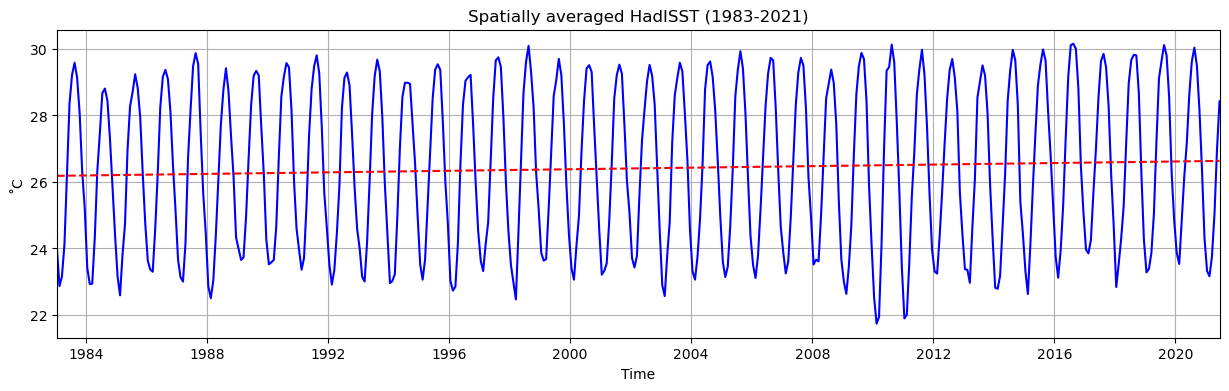

In [143]:
hadisst83.mean(['latitude', 'longitude']).plot(figsize=(15,4), color='blue')
plt.plot(hadisst83.time, trend_dict_hadisst83['sst_trend_line_lr'], color='r', linestyle='dashed')
plt.grid()
plt.ylabel('˚C')
plt.xlim(hadisst83.time[0], hadisst83.time[-1])
plt.title('Spatially averaged HadISST (1983-2021)')
plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/Obs/trend/trend_lines_hadisst83.pdf');

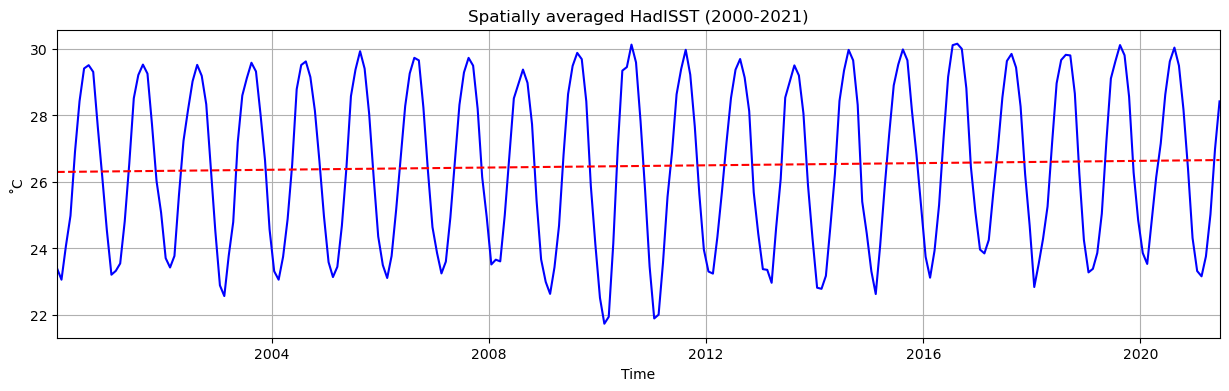

In [144]:
hadisst20.mean(['latitude', 'longitude']).plot(figsize=(15,4), color='blue')
plt.plot(hadisst20.time, trend_dict_hadisst20['sst_trend_line_lr'], color='r', linestyle='dashed')
plt.grid()
plt.ylabel('˚C')
plt.xlim(hadisst20.time[0], hadisst20.time[-1])
plt.title('Spatially averaged HadISST (2000-2021)')
plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/Obs/trend/trend_lines_hadisst20.pdf');

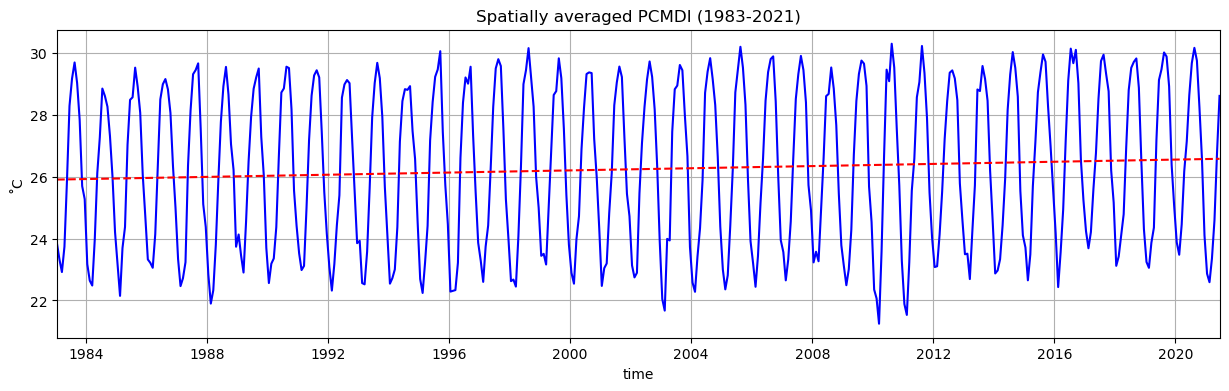

In [145]:
pcmdi83.mean(['lat', 'lon']).plot(figsize=(15,4), color='blue')
plt.plot(pcmdi83.time, trend_dict_pcmdi83['tosbcs_trend_line_lr'], color='r', linestyle='dashed')
plt.grid()
plt.ylabel('˚C')
plt.xlim(pcmdi83.time[0], pcmdi83.time[-1])
plt.title('Spatially averaged PCMDI (1983-2021)')
plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/Obs/trend/trend_lines_pcmdi83.pdf');

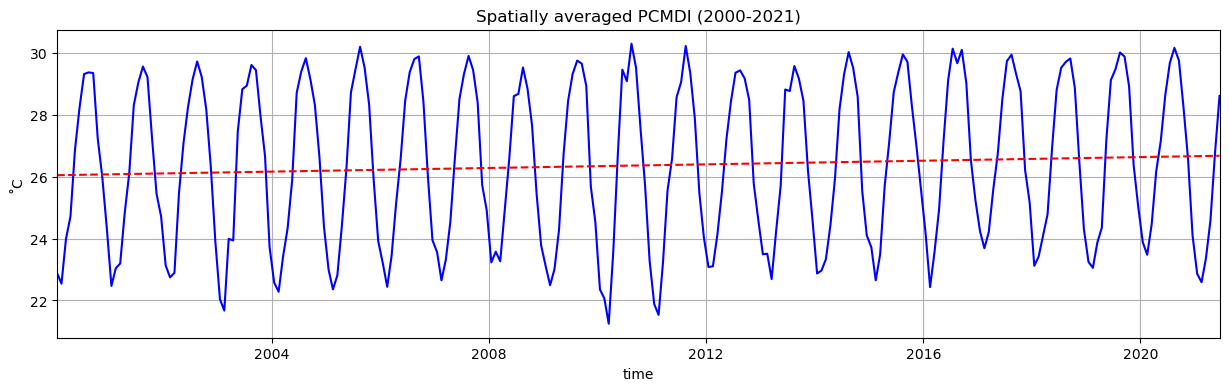

In [146]:
pcmdi20.mean(['lat', 'lon']).plot(figsize=(15,4), color='blue')
plt.plot(pcmdi20.time, trend_dict_pcmdi20['tosbcs_trend_line_lr'], color='r', linestyle='dashed')
plt.grid()
plt.ylabel('˚C')
plt.xlim(pcmdi20.time[0], pcmdi20.time[-1])
plt.title('Spatially averaged PCMDI (2000-2021)')
plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/Obs/trend/trend_lines_pcmdi20.pdf');

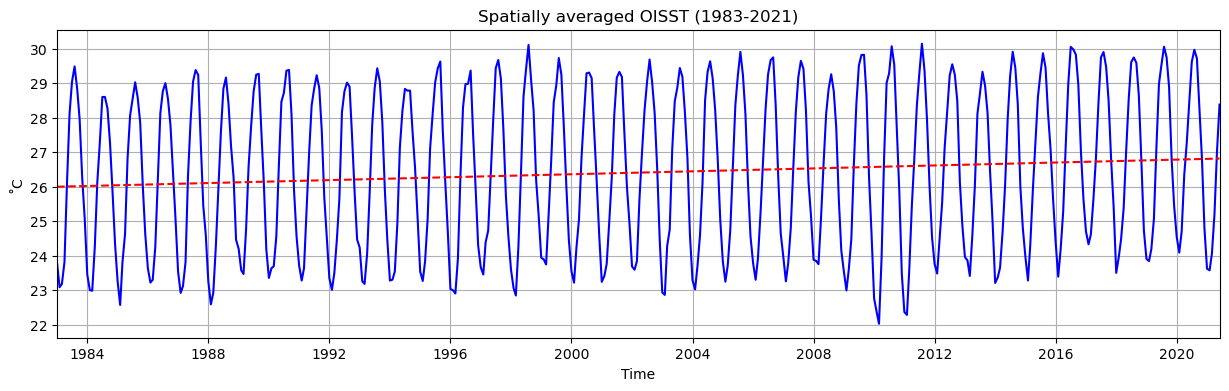

In [147]:
oisst83.mean(['lat', 'lon']).plot(figsize=(15,4), color='blue')
plt.plot(oisst83.time, trend_dict_oisst83['sst_trend_line_lr'], color='r', linestyle='dashed')
plt.grid()
plt.ylabel('˚C')
plt.xlim(oisst83.time[0], oisst83.time[-1])
plt.title('Spatially averaged OISST (1983-2021)')
plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/Obs/trend/trend_lines_oisst83.pdf');

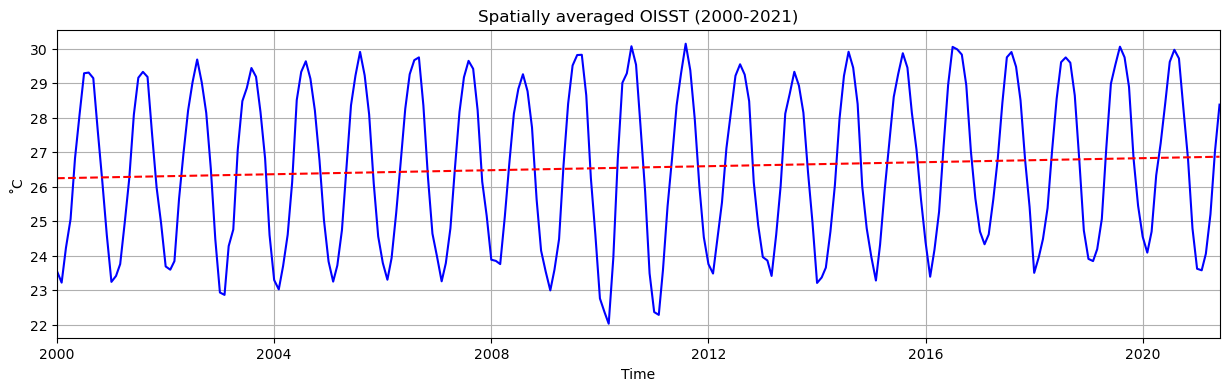

In [148]:
oisst20.mean(['lat', 'lon']).plot(figsize=(15,4), color='blue')
plt.plot(oisst20.time, trend_dict_oisst20['sst_trend_line_lr'], color='r', linestyle='dashed')
plt.grid()
plt.ylabel('˚C')
plt.xlim(oisst20.time[0], oisst20.time[-1])
plt.title('Spatially averaged OISST (2000-2021)')
plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/Obs/trend/trend_lines_oisst20.pdf');

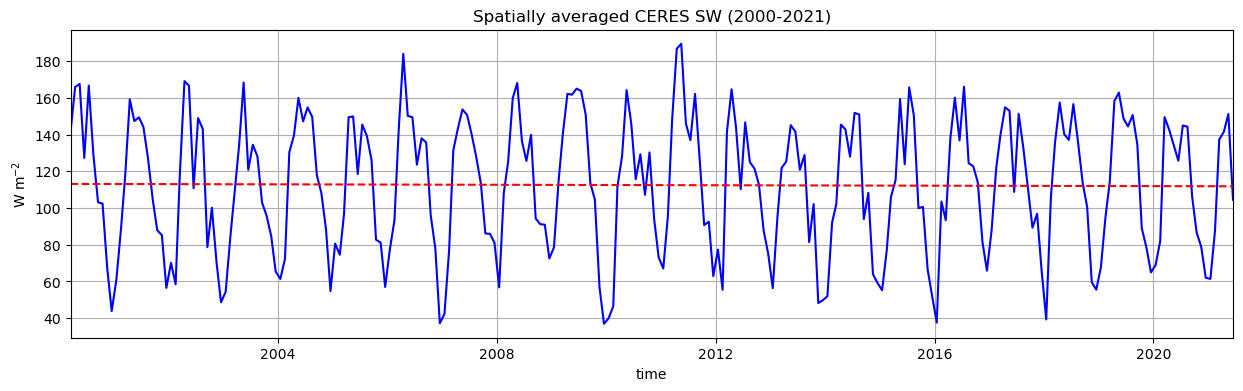

In [149]:
sw.mean(['lat', 'lon']).plot(figsize=(15,4), color='blue')
plt.plot(sw.time, trend_dict_sw['sw_trend_line_lr'], color='r', linestyle='dashed')
plt.grid()
plt.ylabel(r'W m$^{-2}$')
plt.xlim(sw.time[0], sw.time[-1])
plt.title('Spatially averaged CERES SW (2000-2021)')
plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/Obs/trend/trend_lines_sw.pdf');

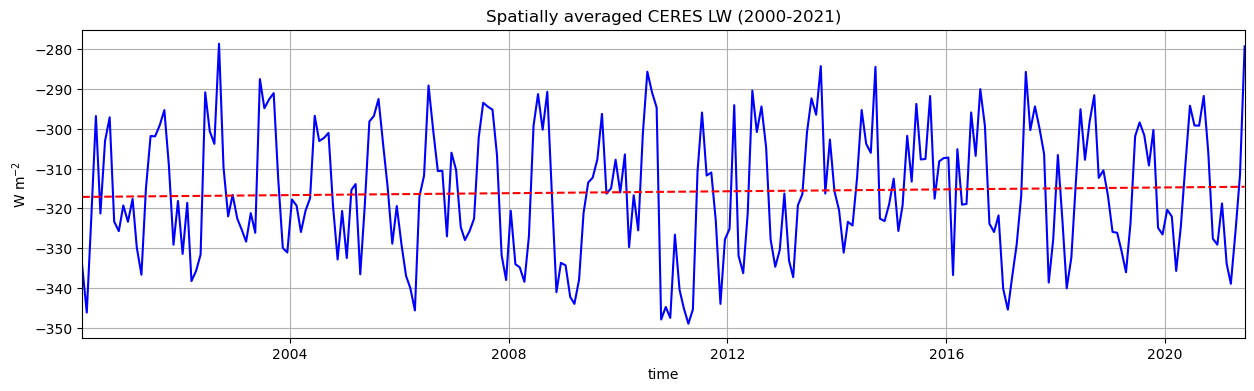

In [150]:
lw.mean(['lat', 'lon']).plot(figsize=(15,4), color='blue')
plt.plot(lw.time, trend_dict_lw['lw_trend_line_lr'], color='r', linestyle='dashed')
plt.grid()
plt.ylabel(r'W m$^{-2}$')
plt.xlim(lw.time[0], lw.time[-1])
plt.title('Spatially averaged CERES LW (2000-2021)')
plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/Obs/trend/trend_lines_lw.pdf');